In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import math as m

In [ ]:
N = 10000

N_w_top = 50
N_w_bottom = 50
N_t = 200
N_b = 200
N_e = 100
N_full = N + N_w_top + N_w_bottom + N_t + N_b + N_e
N_u = N_w_top + N_w_bottom + N_t + N_b


L = 30
D = 0.5
#u_bc = 0.5
rho = 1.0
mu = 0.00125

u_factor = 1.5


tf.random.set_seed(1234)

In [ ]:
def get_value_u_x(x):
  #u = 4*(0.25-tf.square(x))
  u = 24*x*(0.5-x)

  #u = tf.convert_to_tensor(u)
  return u

In [ ]:
#west_top
x_w_top = tf.ones((N_w_top,1),dtype = 'float64')*0.0
#y_w = tf.random.uniform((N_w,1),-D/2,D/2,dtype = 'float64')
y_w_top = tf.random.uniform((N_w_top,1),0,D,dtype='float64')
X_w_top = tf.cast(tf.concat([x_w_top, y_w_top], axis = 1),tf.float64)
u_w_x = get_value_u_x(y_w_top)/u_factor
u_w_y = tf.ones((N_w_top,1),dtype = 'float64')*0.0
u_w_top = tf.concat([u_w_x, u_w_y], axis = 1)

#west_bottom
x_w_bottom = tf.ones((N_w_bottom,1),dtype = 'float64')*0.0
y_w_bottom = tf.random.uniform((N_w_bottom,1),-D,0,dtype = 'float64')
X_w_bottom = tf.cast(tf.concat([x_w_bottom, y_w_bottom], axis = 1),tf.float64)
u_w_x = tf.ones((N_w_bottom,1),dtype = 'float64')*0.0
u_w_y = tf.ones((N_w_bottom,1),dtype = 'float64')*0.0
u_w_bottom = tf.concat([u_w_x, u_w_y], axis = 1)

#west
X_w = tf.concat([np.vstack([x_w_top, x_w_bottom]),np.vstack([y_w_top, y_w_bottom])],axis = 1)
u_w = np.vstack([u_w_top, u_w_bottom])

#top
x_t = tf.random.uniform((N_t,1),0,L,dtype = 'float64')
y_t = tf.ones((N_t,1),dtype = 'float64')*D
X_t = tf.concat([x_t, y_t], axis = 1)
u_t = tf.ones((N_t,2),dtype='float64')*0.0

#bottom
x_b = tf.random.uniform((N_b,1),0,L,dtype = 'float64')
y_b = tf.ones((N_b,1),dtype = 'float64')*-D
X_b = tf.concat([x_b, y_b], axis = 1)
u_b = tf.ones((N_b,2),dtype='float64')*0.0

#east
x_e = tf.ones((N_e,1),dtype = 'float64')*L
y_e = tf.random.uniform((N_e,1),-D,D,dtype = 'float64')
p_e = tf.ones((N_e,1),dtype='float64')*0
X_e = tf.concat([x_e, y_e],axis = 1)

In [ ]:
x = tf.random.uniform((N,1),0,L,dtype='float64')
y = tf.random.uniform((N,1),-D,D,dtype = 'float64')
X = tf.concat([x,y],axis=1)

In [ ]:
X_u = np.vstack([X_w, X_t, X_b])
u_u = np.vstack([u_w,u_t,u_b])

In [ ]:
X_main = np.vstack([X_w, X_e, X_t, X_b, X])

In [ ]:
data_train = pd.read_csv("drive/MyDrive/PINN files/Backward_Facing_Step/backward_facing_step_data_file.csv")
data_train = tf.convert_to_tensor(data_train)

X_data_train = data_train[:,0:2]
#print(X_data_train)
#data_train[:,4:5] = data_train[:,4:5]*10
Y_data_train = data_train[:,2:5]
print(data_train)

<ipython-input-11-badac7c22e66>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(X_e[:,0], X_e[:,1], c= 'blue', marker='x', vmin=-1, vmax=1)
<ipython-input-11-badac7c22e66>:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(X_b[:,0], X_b[:,1], c= 'yellow', marker='o', vmin=-1, vmax=1)
<ipython-input-11-badac7c22e66>:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(X_t[:,0], X_t[:,1], c= 'yellow',marker='o', vmin=-1, vmax=1)


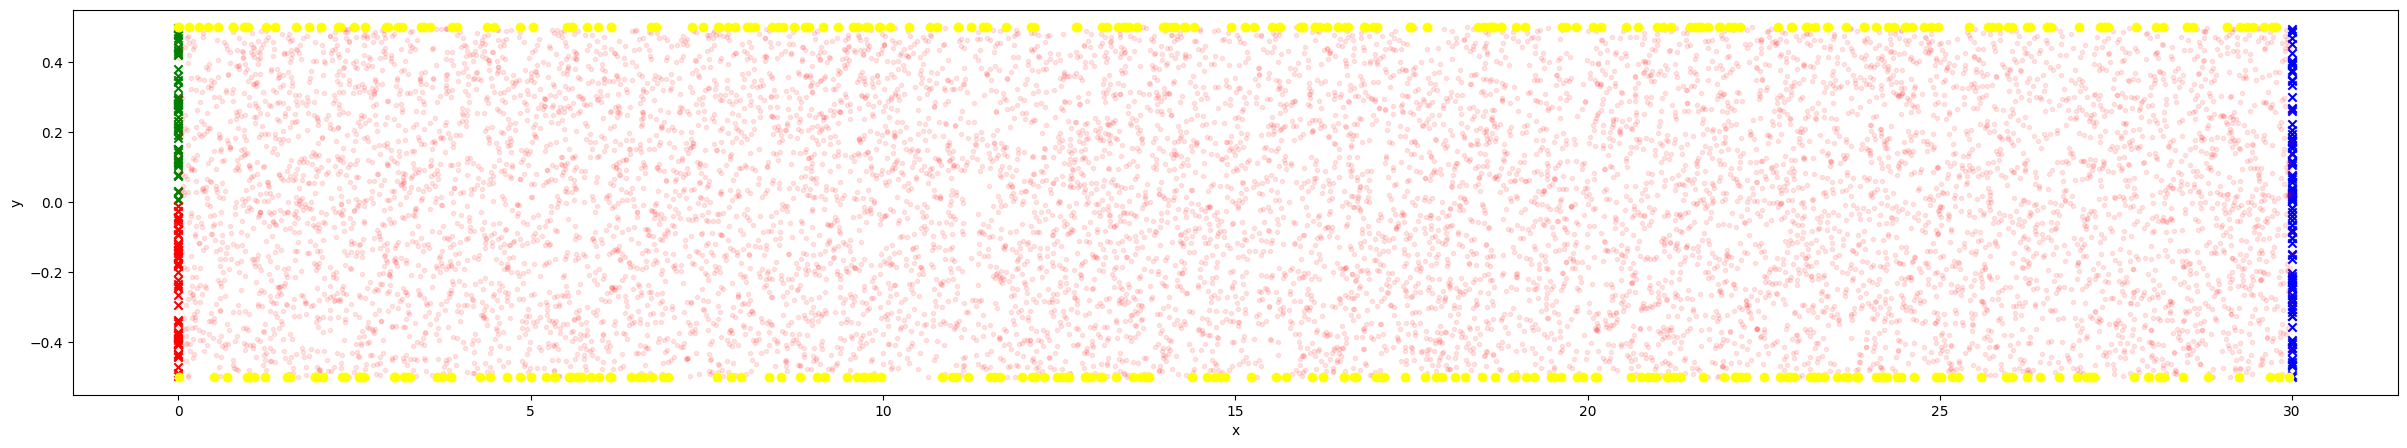

In [ ]:
fig = plt.figure(figsize=(30,5))
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X_w_top[:,0], X_w_top[:,1], c= 'green', marker='x')
plt.scatter(X_w_bottom[:,0], X_w_bottom[:,1], c= 'red', marker='x')
plt.scatter(X_e[:,0], X_e[:,1], c= 'blue', marker='x', vmin=-1, vmax=1)
plt.scatter(X[:,0], X[:,1], c= 'red', marker='.',alpha=0.1)
plt.scatter(X_b[:,0], X_b[:,1], c= 'yellow', marker='o', vmin=-1, vmax=1)
plt.scatter(X_t[:,0], X_t[:,1], c= 'yellow',marker='o', vmin=-1, vmax=1)

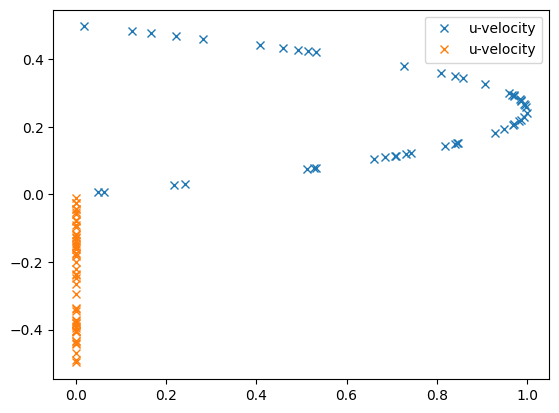

In [ ]:
plt.plot(u_w_top[:,0:1],y_w_top,'x',label='u-velocity')
plt.plot(u_w_bottom[:,0:1],y_w_bottom,'x',label='u-velocity')
plt.legend()
plt.show()

In [ ]:
def calculate_loss(y_pred,y_actual,N):
  return tf.norm(y_actual-y_pred,2)/(N)

In [ ]:
@tf.function
def train_pinn(x):
  with tf.GradientTape(persistent = True) as higher_tape:
    higher_tape.watch(x)
    with tf.GradientTape(persistent = True) as tape:
      tape.watch(x)

      V = tf.cast(model(x),tf.float64)
      u = V[:,0:1]*u_factor
      v = V[:,1:2]
      p = V[:,2:3]
    # ----------------------------------------------------------------------------
      # first order gradients
      u_dx = tape.gradient(u,x)
      du_dx = u_dx[:,0:1]
      du_dy = u_dx[:,1:2]

      v_dx = tape.gradient(v,x)
      dv_dx = v_dx[:,0:1]
      dv_dy = v_dx[:,1:2]

      p_dx = tape.gradient(p,x)
      dp_dx = p_dx[:,0:1]
      dp_dy = p_dx[:,1:2]
    # ----------------------------------------------------------------------------

      # second order gradients
      u_ddx = higher_tape.gradient(du_dx,x)
      ddu_ddx = u_ddx[:,0:1]
      u_ddy = higher_tape.gradient(du_dy,x)
      ddu_ddy = u_ddy[:,1:2]

      v_ddx = higher_tape.gradient(dv_dx,x)
      ddv_ddx = v_ddx[:,0:1]
      v_ddy = higher_tape.gradient(dv_dy,x)
      ddv_ddy = v_ddx[:,1:2]

    # ----------------------------------------------------------------------------

      #X momemtum
      x_mom = u*du_dx + v*du_dy + (1/rho)*dp_dx - (mu/rho)*ddu_ddx - (mu/rho)*ddu_ddy
      x_mom_loss = tf.norm(x_mom,2)/N_full

      #Y momemtum
      y_mom = u*dv_dx + v*dv_dy + (1/rho)*dp_dy - (mu/rho)*ddv_ddx - (mu/rho)*ddv_ddy
      y_mom_loss = tf.norm(y_mom,2)/N_full

      #Continiuty
      cont = du_dx + dv_dy
      cont_loss = tf.norm(cont,2)/N_full
      ns_loss = x_mom_loss + y_mom_loss + cont_loss
    # ----------------------------------------------------------------------------

      #West Boundary loss

      V_w = tf.cast(model(X_u),tf.float64)
      u_w_bc = V_w[:,0:1]*u_factor
      v_w_bc = V_w[:,1:2]
      p_w_bc = V_w[:,2:3]
      V_w = tf.concat([u_w_bc,v_w_bc,p_w_bc],axis=1)
      bc_w_loss = calculate_loss(V_w[:,0:2],u_u,N_u)

      # East Boundary loss

      V_e = tf.cast(model(X_e),tf.float64)
      bc_e_loss = calculate_loss(V_e[:,2:3],p_e,N_e)

      bc_loss = bc_w_loss + bc_e_loss

    # ----------------------------------------------------------------------------

      # NN loss
      V_nn =  tf.cast(model(X_data_train),tf.float64)
      u_nn = V_nn[:,0:1]*u_factor
      v_nn = V_nn[:,1:2]
      p_nn = V_nn[:,2:3]
      V_nn_f = tf.concat([u_nn,v_nn,p_nn],axis=1)
      nn_loss = calculate_loss(V_nn_f,Y_data_train,200)

      total_loss = ns_loss + bc_loss + nn_loss
      #total_loss = ns_loss + bc_loss
  grads = tape.gradient(total_loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  return total_loss, ns_loss, bc_loss, nn_loss

In [ ]:
nnode = 100
act = 'tanh'


model = tf.keras.Sequential([
    layers.Dense(nnode,input_shape=(2,),activation=act),
    layers.Dense(nnode,activation=act),
    layers.Dense(nnode,activation=act),
    layers.Dense(nnode,activation=act),
    layers.Dense(nnode,activation=act),
    layers.Dense(nnode,activation=act),
    layers.Dense(nnode,activation=act),
    layers.Dense(nnode,activation=act),
    #layers.Dense(nnode-150,activation=act),
    layers.Dense(3,activation=act)
])

#loss_ns,bc_loss = train_pinn(t)
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000,10000,50000,70000],[1e-3,5e-4,1e-4,1e-5,1e-6])
#lr = 0.001
optimizer = keras.optimizers.Adam(learning_rate=lr)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
epochs = 100000
icount = 1000

loss_array = []
print('Epoch      Total loss      NS_loss       BC_loss       NN_loss')

for epoch in range(epochs):
  total_loss, ns_loss, bc_loss, nn_loss = train_pinn(X_main)
  tl = total_loss.numpy()
  loss_array.append(tl)
  if epoch % icount == 1:
        print('  %d          %.4f          %.4f          %.4f         %.4f' % (epoch, total_loss, ns_loss, bc_loss, nn_loss))

Epoch      Total loss      NS_loss       BC_loss       NN_loss
  1          0.1846          0.0030          0.1225         0.0590
  1001          0.0054          0.0008          0.0024         0.0023
  2001          0.0052          0.0006          0.0015         0.0031
  3001          0.0051          0.0005          0.0027         0.0018
  4001          0.0047          0.0006          0.0029         0.0012
  5001          0.0033          0.0005          0.0016         0.0012
  6001          0.0014          0.0004          0.0006         0.0004
  7001          0.0018          0.0004          0.0006         0.0008
  8001          0.0014          0.0004          0.0005         0.0005
  9001          0.0019          0.0004          0.0009         0.0007
  10001          0.0024          0.0004          0.0010         0.0010
  11001          0.0007          0.0003          0.0003         0.0001


KeyboardInterrupt: ignored

In [ ]:
model.save('drive/MyDrive/PINN files/Backward_Facing_Step/PINN_Backward_Facing_step.h5')

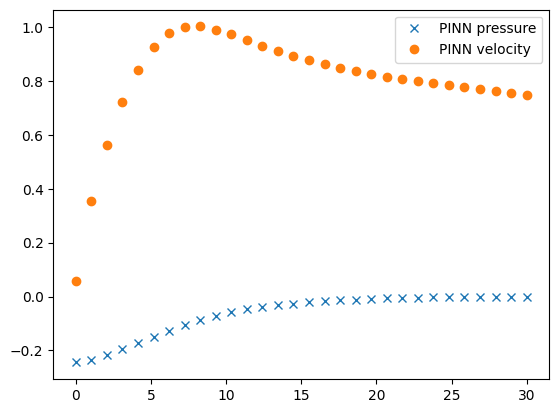

In [ ]:
#plt.plot(data_plot[:,0:1],data_plot[:,1:2],label='pressure')
#plt.plot(u_plot[:,0:1],u_plot[:,1:2],label='u-velocity')
#x_test = tf.random.uniform((30,1),0,L,dtype='float32')
#y_test = tf.ones((30,1),dtype='float32')*0.0
x_test = np.linspace(0,L,30)
x_test = tf.reshape(x_test,(30,1))
y_test = np.zeros(30)
y_test = tf.reshape(y_test,(30,1))

#print(y_test)
X_test = tf.concat((x_test,y_test),axis=1)

u_pred = model(X_test)

plt.plot(x_test,u_pred[:,2:3],'x',label='PINN pressure')
plt.plot(x_test,u_pred[:,0:1]*u_factor,'o',label='PINN velocity')
plt.legend()
plt.show()

1.122465 -0.051766396


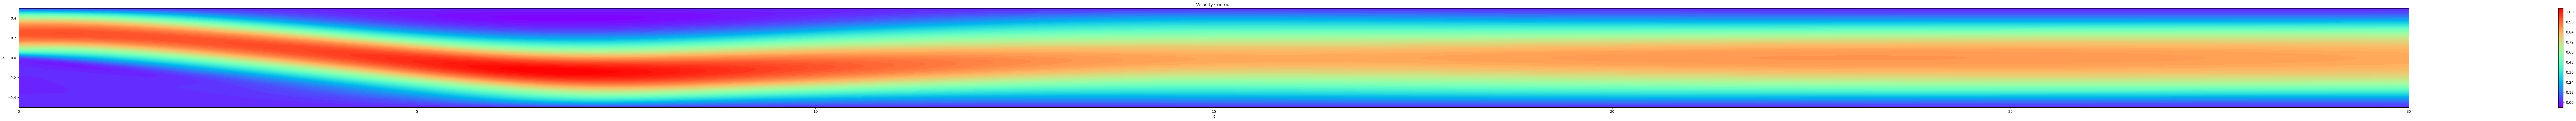

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Set up meshgrid
N = 300
yspace = np.linspace(-D, D, N + 1)
xspace = np.linspace(0,L, N + 1)
Xplt, Yplt = np.meshgrid(xspace,yspace)
Xgrid = np.vstack([Xplt.flatten(),Yplt.flatten()]).T
upred = model(tf.cast(Xgrid,tf.float32))
U = (upred[:,0:1]*u_factor).numpy().reshape(N+1,N+1)
print(np.max(U),np.min(U))
fig = plt.figure(figsize=(150,5))
levels = np.linspace(0, 200, 200)
cp = plt.contourf(Xplt, Yplt, U,levels=101,cmap='rainbow')
for c in cp.collections:
    c.set_edgecolor("face")
plt.colorbar(cp)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Velocity Contour')
plt.show()

In [ ]:
data_u_x7 = pd.read_csv("drive/MyDrive/PINN files/Backward_Facing_Step/velocity at x 7.csv")
data_u_x7.head()
data_u_x7 = tf.convert_to_tensor(data_u_x7)

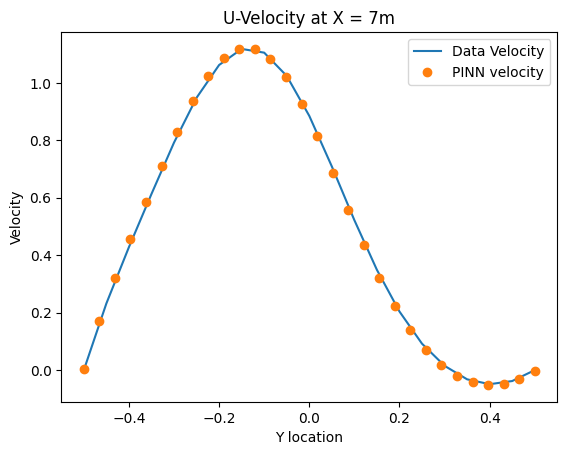

In [ ]:
plt.plot(data_u_x7[:,0:1],data_u_x7[:,1:2],label='Data Velocity')
#plt.plot(u_plot[:,0:1],u_plot[:,1:2],label='u-velocity')
#x_test = np.linspace(0,L,30)
#x_test = tf.reshape(x_test,(30,1))
#y_test = np.zeros(30)
#y_test = tf.reshape(y_test,(30,1))

x_test = tf.ones((30,1),dtype='float64')*7
y_test = np.linspace(-D,D,30)
y_test = tf.reshape(y_test,(30,1))

X_test = tf.concat((x_test,y_test),axis=1)

u_pred = model(X_test)

#plt.plot(x_test,u_pred[:,2:3],'x',label='PINN pressure')
plt.plot(y_test,u_pred[:,0:1]*u_factor,'o',label='PINN velocity')
plt.xlabel("Y location")
plt.ylabel("Velocity")
plt.title("U-Velocity at X = 7m")
plt.legend()
plt.show()

In [ ]:
print(X_test)

tf.Tensor(
[[ 7.         -0.5       ]
 [ 7.         -0.46551724]
 [ 7.         -0.43103448]
 [ 7.         -0.39655172]
 [ 7.         -0.36206897]
 [ 7.         -0.32758621]
 [ 7.         -0.29310345]
 [ 7.         -0.25862069]
 [ 7.         -0.22413793]
 [ 7.         -0.18965517]
 [ 7.         -0.15517241]
 [ 7.         -0.12068966]
 [ 7.         -0.0862069 ]
 [ 7.         -0.05172414]
 [ 7.         -0.01724138]
 [ 7.          0.01724138]
 [ 7.          0.05172414]
 [ 7.          0.0862069 ]
 [ 7.          0.12068966]
 [ 7.          0.15517241]
 [ 7.          0.18965517]
 [ 7.          0.22413793]
 [ 7.          0.25862069]
 [ 7.          0.29310345]
 [ 7.          0.32758621]
 [ 7.          0.36206897]
 [ 7.          0.39655172]
 [ 7.          0.43103448]
 [ 7.          0.46551724]
 [ 7.          0.5       ]], shape=(30, 2), dtype=float64)
